In [2]:
import pandas as pd
import rasterio
from rasterstats import zonal_stats
from osgeo import gdal
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from shapely.geometry import Point
from shapely.geometry import Polygon
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pyproj

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#read tif file
day_274 = pd.read_csv("D:/nightlight study/fl_2022_274.csv")

In [3]:
day_274.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [4]:
day_274.shape

(2869587, 8)

In [5]:
day_274['_mean'].count()

542106

In [6]:
# Merge the dataframes on the 'id' column
day_4_6 = pd.merge(day_04, day_05, on='id')
day_4_6 = pd.merge(day_4_6, day_06, on='id')

# Calculate the maximum mean value for each id
day_4_6['max_mean'] = day_4_6[['_mean_x', '_mean_y', '_mean']].max(axis=1)

# Drop the individual 'mean' columns
day_4_6 = day_4_6.drop(['_mean_x', '_mean_y', '_mean'], axis=1)

# Rename the 'max_mean' column to 'mean'
day_4_6 = day_4_6.rename(columns={'max_mean': 'mean'})
day_4_6 = day_4_6[["id","mean"]]

day_4_6.head()

NameError: name 'day_04' is not defined

In [28]:
day_4_6['mean'].count()

30346

In [4]:
wind = pd.read_csv("D:/nightlight study/Florida_Akshay.csv")
wind.head()

,ID,Center_Latitude,Center_Longitude,Vmax
0,0,32.224223,-87.451826,18.872683
1,1,32.219746,-87.452504,18.866529
2,2,32.215270,-87.453181,18.909298
3,3,32.210793,-87.453858,18.903135
4,4,32.206316,-87.454535,18.896965


In [5]:
wind = wind[["ID","Vmax"]]
wind.head()

,ID,Vmax
0,0,18.872683
1,1,18.866529
2,2,18.909298
3,3,18.903135
4,4,18.896965


In [6]:
landcover_zonal = pd.read_csv("D:/nightlight study/landcover_zonal_Florida.csv")
histo_columns = ['HISTO_0', 'HISTO_1', 'HISTO_3', 'HISTO_4', 'HISTO_6', 'HISTO_7',
                 'HISTO_8', 'HISTO_9', 'HISTO_10', 'HISTO_14', 'HISTO_15', 
                 'HISTO_16', 'HISTO_17', 'HISTO_18', 'HISTO_NODATA']

# Convert HISTO columns to percentages
landcover_zonal[histo_columns] = landcover_zonal[histo_columns].div(landcover_zonal[histo_columns].sum(axis=1), axis=0) * 100
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
landcover_zonal.shape

(2869587, 20)

In [10]:
landcover_zonal.describe()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
count,2.869587e+06,2.869587e+06,2.869587e+06,2.869587e+06,2.869587e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06,2.263828e+06
mean,1.434794e+06,1.609478e+06,-1.750593e+06,1.609978e+06,-1.751093e+06,2.594725e-02,3.121913e-05,4.621494e+00,3.734352e-02,1.762164e-01,1.026153e+00,1.137760e-05,7.365143e-01,7.183839e-06,9.470279e+00,4.567325e+00,1.028247e-01,4.090330e+00,9.395936e-01,7.420593e+01
std,8.283786e+05,2.455182e+05,2.434975e+05,2.455182e+05,2.434975e+05,7.302946e-01,2.574040e-02,1.522863e+01,7.445504e-01,1.739659e+00,5.802961e+00,1.372608e-02,5.042180e+00,6.492462e-03,2.457536e+01,1.740347e+01,1.725802e+00,1.604158e+01,7.985033e+00,4.357711e+01
min,1.000000e+00,1.184478e+06,-2.172093e+06,1.184978e+06,-2.172593e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.173975e+05,1.396978e+06,-1.961593e+06,1.397478e+06,-1.962093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.434794e+06,1.609478e+06,-1.750593e+06,1.609978e+06,-1.751093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
75%,2.152190e+06,1.821978e+06,-1.539593e+06,1.822478e+06,-1.540093e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
max,2.869587e+06,2.034478e+06,-1.329093e+06,2.034978e+06,-1.329593e+06,1.000000e+02,3.010381e+01,1.000000e+02,8.345588e+01,9.653979e+01,1.000000e+02,2.041522e+01,1.000000e+02,7.266436e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02


In [11]:
landcover_zonal[landcover_zonal["HISTO_17"]>0].shape

(305277, 20)

In [15]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [16]:
import netCDF4 as nc
import pandas as pd

In [7]:
rainfall = pd.read_csv("D:/nightlight study/September_29.csv")
rainfall.head()

,Unnamed: 0,Center_Latitude,Center_Longitude,Rainfall
0,0,32.219746,-87.452504,36.787315
1,1,32.215270,-87.453181,36.787315
2,2,32.210793,-87.453858,36.787315
3,3,32.206316,-87.454535,36.787315
4,4,32.201839,-87.455211,36.787315


In [8]:
rainfall = rainfall.rename(columns={'Unnamed: 0': 'id'})

In [9]:
night_month = pd.read_csv("D:/nightlight study/fl_a3_i9.csv")
night_month.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [15]:
night_month.shape

(2869587, 8)

In [16]:
night_month['_mean'].count()

595907

In [10]:
night_month = night_month.rename(columns={'_mean': 'nightlight_prev'})
night_month = night_month[["id","nightlight_prev"]]
night_month.head()

,id,nightlight_prev
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [11]:
night_month = night_month.dropna()
night_month.head()

,id,nightlight_prev
5361,5362,0.498923
5362,5363,0.002193
5363,5364,0.000000
7046,7047,0.000000
7047,7048,0.023106


In [20]:
landcover_zonal.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
wind.head()

,ID,Vmax
0,0,18.872683
1,1,18.866529
2,2,18.909298
3,3,18.903135
4,4,18.896965


In [22]:
day_274.head()

,id,left,top,right,bottom,_count,_sum,_mean
0,1,1.184478e+06,-1.329093e+06,1.184978e+06,-1.329593e+06,NaN,NaN,NaN
1,2,1.184478e+06,-1.329593e+06,1.184978e+06,-1.330093e+06,NaN,NaN,NaN
2,3,1.184478e+06,-1.330093e+06,1.184978e+06,-1.330593e+06,NaN,NaN,NaN
3,4,1.184478e+06,-1.330593e+06,1.184978e+06,-1.331093e+06,NaN,NaN,NaN
4,5,1.184478e+06,-1.331093e+06,1.184978e+06,-1.331593e+06,NaN,NaN,NaN


In [12]:
day_274=day_274.dropna()

In [13]:
day_274.shape

(542106, 8)

In [14]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(day_274,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left_x,top_x,right_x,bottom_x,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Center_Latitude,Center_Longitude,Rainfall
0,5362,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.250000,0.0,0.0,0.0,0.0,98.750000,5362.0,21.133494,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.256606,0.179624,0.700000,0.498923,30.868865,-87.635473,36.496124
1,5363,1.185978e+06,-1.479593e+06,1.186478e+06,-1.480093e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,62.352941,0.0,0.0,0.0,0.0,37.647059,5363.0,21.130450,1.185978e+06,-1.479593e+06,1.186478e+06,-1.480093e+06,0.116311,0.080190,0.689446,0.002193,30.864379,-87.636115,36.496124
2,5364,1.185978e+06,-1.480093e+06,1.186478e+06,-1.480593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,23.529412,0.0,0.0,0.0,0.0,76.470588,5364.0,21.127441,1.185978e+06,-1.480093e+06,1.186478e+06,-1.480593e+06,0.002987,0.000896,0.300000,0.000000,30.859893,-87.636758,36.496124
3,7047,1.186478e+06,-1.478093e+06,1.186978e+06,-1.478593e+06,0.0,0.0,2.768166,0.0,0.0,0.0,0.0,0.0,0.0,35.986159,0.0,0.0,0.0,0.0,61.245675,7047.0,21.140300,1.186478e+06,-1.478093e+06,1.186978e+06,-1.478593e+06,0.781308,0.703023,0.899804,0.000000,30.877190,-87.629024,36.496124
4,7048,1.186478e+06,-1.478593e+06,1.186978e+06,-1.479093e+06,0.0,0.0,7.266436,0.0,0.0,0.0,0.0,0.0,0.0,65.743945,0.0,0.0,0.0,0.0,26.989619,7048.0,21.196257,1.186478e+06,-1.478593e+06,1.186978e+06,-1.479093e+06,0.718019,0.507459,0.706748,0.023106,30.872704,-87.629667,36.496124


In [15]:
regression_df = regression_df.drop(['id', 'left_x', 'top_x', 'right_x', 'bottom_x','ID','Center_Latitude',
                                    'Center_Longitude','HISTO_NODATA'], axis=1)
regression_df.shape

(541675, 24)

In [27]:
regression_df.columns

Index(['HISTO_0', 'HISTO_1', 'HISTO_3', 'HISTO_4', 'HISTO_6', 'HISTO_7',
       'HISTO_8', 'HISTO_9', 'HISTO_10', 'HISTO_14', 'HISTO_15', 'HISTO_16',
       'HISTO_17', 'HISTO_18', 'Vmax', 'left_y', 'top_y', 'right_y',
       'bottom_y', '_count', '_sum', '_mean', 'nightlight_prev', 'Rainfall'],
      dtype='object')

In [16]:
#remove rows with no urban
#only keep rows with values for target column

regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(283109, 24)

In [29]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Rainfall
count,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,2.831090e+05,2.831090e+05,2.831090e+05,2.831090e+05,2.831090e+05,283109.000000,283109.000000,283109.000000,283109.000000
mean,0.074023,0.000248,21.826132,0.129787,0.628230,4.478863,0.000082,3.365309,0.000057,22.069884,14.914361,0.424835,28.912849,1.801344,12.062184,1.674939e+06,-1.589905e+06,1.675439e+06,-1.590405e+06,1.503841e+00,8.612312,6.036626,6.652150,8.990427
std,1.157915,0.072785,26.107920,1.209900,2.965068,10.915824,0.038512,9.923095,0.018359,27.184718,26.243753,3.173588,32.510571,7.754262,25.372623,1.923877e+05,1.316169e+05,1.923877e+05,1.316169e+05,4.212696e-01,23.790963,15.734920,16.051540,10.149186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,0.000000,1.188478e+06,-2.067093e+06,1.188978e+06,-2.067593e+06,6.797226e-08,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.920415,0.000000,0.000000,1.562478e+06,-1.683593e+06,1.562978e+06,-1.684093e+06,1.326399e+00,0.370824,0.240656,0.000000,1.620249
50%,0.000000,0.000000,9.688581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.926471,0.000000,0.000000,11.764706,0.000000,0.000000,1.726478e+06,-1.544093e+06,1.726978e+06,-1.544593e+06,1.348752e+00,0.898302,0.600000,0.650000,5.311607
75%,0.000000,0.000000,38.602941,0.000000,0.000000,3.308824,0.000000,1.562500,0.000000,36.328125,18.339100,0.000000,45.674740,0.000000,0.000000,1.803978e+06,-1.485093e+06,1.804478e+06,-1.485593e+06,2.000000e+00,5.000000,3.741100,5.130306,12.833522
max,93.771626,30.103806,99.653979,74.632353,86.159170,99.632353,20.415225,99.653979,7.266436,99.653979,99.653979,96.539792,100.000000,99.653979,97.650806,1.999978e+06,-1.388093e+06,2.000478e+06,-1.388593e+06,3.000000e+00,1416.900000,708.450000,506.950000,63.688004


In [43]:
regression_df.to_csv("D:/nightlight study/ian_regressor.csv")

### Machine Learning Models

#### Linear Regression

In [30]:
regression_df.describe()

,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,Vmax,left_y,top_y,right_y,bottom_y,_count,_sum,_mean,nightlight_prev,Rainfall
count,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,283109.000000,2.831090e+05,2.831090e+05,2.831090e+05,2.831090e+05,2.831090e+05,283109.000000,283109.000000,283109.000000,283109.000000
mean,0.074023,0.000248,21.826132,0.129787,0.628230,4.478863,0.000082,3.365309,0.000057,22.069884,14.914361,0.424835,28.912849,1.801344,12.062184,1.674939e+06,-1.589905e+06,1.675439e+06,-1.590405e+06,1.503841e+00,8.612312,6.036626,6.652150,8.990427
std,1.157915,0.072785,26.107920,1.209900,2.965068,10.915824,0.038512,9.923095,0.018359,27.184718,26.243753,3.173588,32.510571,7.754262,25.372623,1.923877e+05,1.316169e+05,1.923877e+05,1.316169e+05,4.212696e-01,23.790963,15.734920,16.051540,10.149186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.346021,0.000000,0.000000,1.188478e+06,-2.067093e+06,1.188978e+06,-2.067593e+06,6.797226e-08,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.920415,0.000000,0.000000,1.562478e+06,-1.683593e+06,1.562978e+06,-1.684093e+06,1.326399e+00,0.370824,0.240656,0.000000,1.620249
50%,0.000000,0.000000,9.688581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.926471,0.000000,0.000000,11.764706,0.000000,0.000000,1.726478e+06,-1.544093e+06,1.726978e+06,-1.544593e+06,1.348752e+00,0.898302,0.600000,0.650000,5.311607
75%,0.000000,0.000000,38.602941,0.000000,0.000000,3.308824,0.000000,1.562500,0.000000,36.328125,18.339100,0.000000,45.674740,0.000000,0.000000,1.803978e+06,-1.485093e+06,1.804478e+06,-1.485593e+06,2.000000e+00,5.000000,3.741100,5.130306,12.833522
max,93.771626,30.103806,99.653979,74.632353,86.159170,99.632353,20.415225,99.653979,7.266436,99.653979,99.653979,96.539792,100.000000,99.653979,97.650806,1.999978e+06,-1.388093e+06,2.000478e+06,-1.388593e+06,3.000000e+00,1416.900000,708.450000,506.950000,63.688004


In [31]:
nan_count = regression_df.isna().sum()
print(nan_count)

HISTO_0            0
HISTO_1            0
HISTO_3            0
HISTO_4            0
HISTO_6            0
HISTO_7            0
HISTO_8            0
HISTO_9            0
HISTO_10           0
HISTO_14           0
HISTO_15           0
HISTO_16           0
HISTO_17           0
HISTO_18           0
Vmax               0
left_y             0
top_y              0
right_y            0
bottom_y           0
_count             0
_sum               0
_mean              0
nightlight_prev    0
Rainfall           0
dtype: int64


In [17]:
df = regression_df.copy()

#df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('_mean', axis=1)  # Independent variables
y = df['_mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : -0.015047081907668658
HISTO_1 : -0.04521043459658318
HISTO_3 : -0.7779773832422509
HISTO_4 : -0.031772115413915114
HISTO_6 : -0.08646145484875997
HISTO_7 : -0.3319740218342484
HISTO_8 : 0.06433787036368753
HISTO_9 : -0.30548428329268124
HISTO_10 : 0.0531264610420735
HISTO_14 : -0.8733018552066532
HISTO_15 : -0.8094210709894185
HISTO_16 : -0.14388937953548916
HISTO_17 : -1.1988412583955017
HISTO_18 : -0.26179424300724924
Vmax : 0.09333291613770765
left_y : 0.016529606785255863
top_y : 0.06416074663437649
right_y : 0.016529606785254464
bottom_y : 0.06416074663437649
_count : -1.2893294705061573
_sum : 10.450929079630699
nightlight_prev : 5.420464008541306
Rainfall : -0.026294519230366957
R2 score on the test set: 0.9359612891182159


#### Poisson Regression

In [18]:
import statsmodels.api as sm
import pandas as pd

# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Fit the Poisson GLM
X = df[independent_vars]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df[target]

poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print the summary of the model
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  _mean   No. Observations:               283109
Model:                            GLM   Df Residuals:                   283087
Model Family:                 Poisson   Df Model:                           21
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1571e+05
Date:                Tue, 20 Jun 2023   Deviance:                   1.2128e+06
Time:                        11:19:41   Pearson chi2:                 1.81e+06
No. Iterations:                   100   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.069e-06   5.43e-08    1

In [19]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

df = regression_df.copy()
# Assuming your dataframe is named 'df' and the target variable is '_mean'
target = '_mean'
independent_vars = [col for col in df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[independent_vars], df[target], test_size=0.2, random_state=42)

# Scale the independent variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Poisson GLM on the training data
X_train_scaled = sm.add_constant(X_train_scaled)  # Add a constant term for the intercept
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Predict on the test data
X_test_scaled = sm.add_constant(X_test_scaled)  # Add a constant term for the intercept
y_pred = poisson_results.predict(X_test_scaled)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  7015483862831388.0


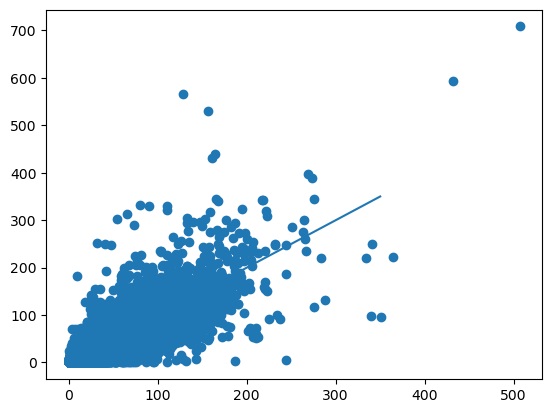

In [36]:
plt.scatter(x=df["nightlight_prev"],y=df["_mean"])
plt.plot([0,350],[0,350])
plt.show()

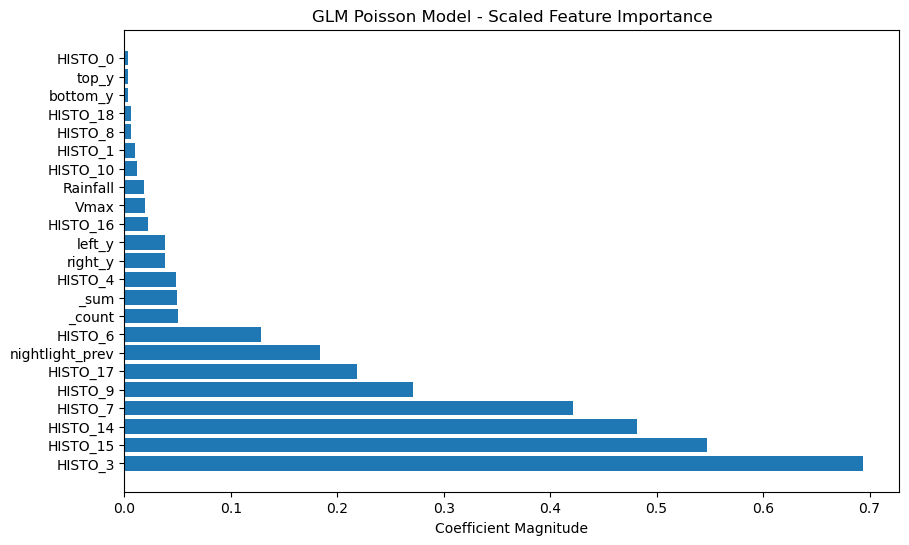

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a pandas DataFrame called 'data'
# X should contain the features used in your model
X = df[independent_vars]
y = df[target]

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a GLM Poisson model on the scaled data
glm_model = sm.GLM(y, sm.add_constant(X_scaled), family=sm.families.Poisson()).fit()

# Get the absolute values of the coefficients
coef_abs = np.abs(glm_model.params[1:])

# Sort the coefficients in descending order
sorted_indices = np.argsort(coef_abs)[::-1]
sorted_coef_abs = coef_abs[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coef_abs)), sorted_coef_abs, align='center')
plt.yticks(range(len(sorted_coef_abs)), sorted_feature_names)
plt.xlabel('Coefficient Magnitude')
plt.title('GLM Poisson Model - Scaled Feature Importance')
plt.show()

### Recovery

In [20]:
day_265 = pd.read_csv("D:/nightlight study/fl_2022_265.csv")
day_265 = day_265[["id","_mean"]]

In [21]:
day_274 = day_274[["id","_mean"]]

In [22]:
day_265.head()

,id,_mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [23]:
df2 = day_265.merge(day_274,on="id",how="inner")
df2.head()

,id,_mean_x,_mean_y
0,5362,0.799569,0.700000
1,5363,0.600877,0.689446
2,5364,0.600000,0.300000
3,7047,0.999509,0.899804
4,7048,0.517415,0.706748


In [45]:
df2.shape

(542106, 3)

In [24]:
df2["outage"] = (df2["_mean_x"] - df2["_mean_y"])/df2["_mean_x"]*100
df2.head()
df2 = df2[["id","outage"]]
df2.head()

,id,outage
0,5362,12.452860
1,5363,-14.739911
2,5364,50.000000
3,7047,9.975431
4,7048,-36.592052


In [48]:
df2.shape

(542106, 2)

In [25]:
df2 = df2[df2["outage"]>0]
df2.shape

(448294, 2)

In [26]:
day_276 = pd.read_csv("D:/nightlight study/fl_2022_276.csv")

In [27]:
day_276 = day_276[["id","_mean"]]
day_276.head()

,id,_mean
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [28]:
regression_df = landcover_zonal.merge(wind,how="left", left_on="id",right_on="ID").fillna(0)
regression_df = regression_df.merge(df2,how="inner",on="id")
regression_df = regression_df.merge(day_276,how="inner",on="id")
regression_df = regression_df.merge(night_month,how="inner",on="id")
regression_df = regression_df.merge(rainfall,how="inner",on="id")
regression_df.head()

,id,left,top,right,bottom,HISTO_0,HISTO_1,HISTO_3,HISTO_4,HISTO_6,HISTO_7,HISTO_8,HISTO_9,HISTO_10,HISTO_14,HISTO_15,HISTO_16,HISTO_17,HISTO_18,HISTO_NODATA,ID,Vmax,outage,_mean,nightlight_prev,Center_Latitude,Center_Longitude,Rainfall
0,5362,1.185978e+06,-1.479093e+06,1.186478e+06,-1.479593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.250000,0.0,0.0,0.0,0.0,98.750000,5362.0,21.133494,12.452860,0.799569,0.498923,30.868865,-87.635473,36.496124
1,5364,1.185978e+06,-1.480093e+06,1.186478e+06,-1.480593e+06,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,23.529412,0.0,0.0,0.0,0.0,76.470588,5364.0,21.127441,50.000000,0.600000,0.000000,30.859893,-87.636758,36.496124
2,7047,1.186478e+06,-1.478093e+06,1.186978e+06,-1.478593e+06,0.0,0.0,2.768166,0.0,0.0,0.0,0.0,0.0,0.0,35.986159,0.0,0.0,0.0,0.0,61.245675,7047.0,21.140300,9.975431,0.999509,0.000000,30.877190,-87.629024,36.496124
3,7050,1.186478e+06,-1.479593e+06,1.186978e+06,-1.480093e+06,0.0,0.0,11.764706,0.0,0.0,0.0,0.0,0.0,0.0,88.235294,0.0,0.0,0.0,0.0,0.000000,7050.0,21.190114,3.819592,0.683582,0.000000,30.863731,-87.630953,36.496124
4,7051,1.186478e+06,-1.480093e+06,1.186978e+06,-1.480593e+06,0.0,0.0,0.346021,0.0,0.0,0.0,0.0,0.0,0.0,68.858131,0.0,0.0,0.0,0.0,30.795848,7051.0,21.187093,43.934164,0.647103,0.000000,30.859245,-87.631595,36.496124


In [29]:
regression_df = regression_df.dropna(subset=['nightlight_prev'])
regression_df.shape

(447945, 28)

In [55]:
regression_df.columns

Index(['id', 'left', 'top', 'right', 'bottom', 'HISTO_0', 'HISTO_1', 'HISTO_3',
       'HISTO_4', 'HISTO_6', 'HISTO_7', 'HISTO_8', 'HISTO_9', 'HISTO_10',
       'HISTO_14', 'HISTO_15', 'HISTO_16', 'HISTO_17', 'HISTO_18',
       'HISTO_NODATA', 'ID', 'Vmax', 'outage', '_mean', 'nightlight_prev',
       'Center_Latitude', 'Center_Longitude', 'Rainfall'],
      dtype='object')

In [30]:
regression_df = regression_df.drop(['id', 'left', 'top', 'right', 'bottom','ID',"Center_Latitude",
                                    "Center_Longitude"], axis=1)
regression_df.shape

(447945, 20)

In [31]:
regression_df = regression_df[regression_df["HISTO_17"]>0]
regression_df.shape

(222654, 20)

In [32]:
regression_df = regression_df.dropna(subset=['_mean'])
regression_df.shape

(222654, 20)

In [60]:
df = regression_df.copy()

df = df.drop("HISTO_NODATA", axis=1)

# Separate independent and dependent variables
X = df.drop('_mean', axis=1)  # Independent variables
y = df['_mean']  # Dependent variable

# Standardize independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Print the model coefficients
print("Model Coefficients:")
for feature, coef in zip(X.columns, reg_model.coef_):
    print(feature, ":", coef)

# Predict on the test set
y_pred = reg_model.predict(X_test)

# Calculate R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Print the R2 score
print("R2 score on the test set:", r2)

Model Coefficients:
HISTO_0 : -0.0032772647197606155
HISTO_1 : 0.0006426635641261319
HISTO_3 : -0.32456931250261817
HISTO_4 : -0.021175242171738613
HISTO_6 : -0.005822534875402122
HISTO_7 : -0.1464062654425617
HISTO_8 : 0.0006426635641268225
HISTO_9 : -0.14260882670058744
HISTO_10 : 0.0006426635641305767
HISTO_14 : -0.39232550161026486
HISTO_15 : -0.28946318939593163
HISTO_16 : 0.020465718886982866
HISTO_17 : -6.042545394342073e-05
HISTO_18 : -0.08064574058741569
Vmax : 0.2042170317408936
outage : 0.6216919452257837
nightlight_prev : 15.98947511214122
Rainfall : -0.010195846988478637
R2 score on the test set: 0.7725556070017227


#### Random Forrest

In [40]:
# Split the data into features (X) and target variable (y)
X = df.drop('_mean', axis=1)
y = df['_mean']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest regressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [41]:
# Train the Random Forest model
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [42]:
# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.4853817393572797
